XGBoost performance metrics
-----------------------
R-squared: 0.96
Root Mean Squared Error: 10251.54
Mean Absolute Error: 4230.39
-----------------------
Linear Regression performance metrics
-----------------------
R-squared: 0.78
Root Mean Squared Error: 24277.42
Mean Absolute Error: 10807.19
-----------------------
Decision Tree performance metrics
-----------------------
R-squared: 0.92
Root Mean Squared Error: 14631.24
Mean Absolute Error: 5031.33
-----------------------
Random Forest performance metrics
-----------------------
R-squared: 0.96
Root Mean Squared Error: 10268.29
Mean Absolute Error: 4118.73
-----------------------


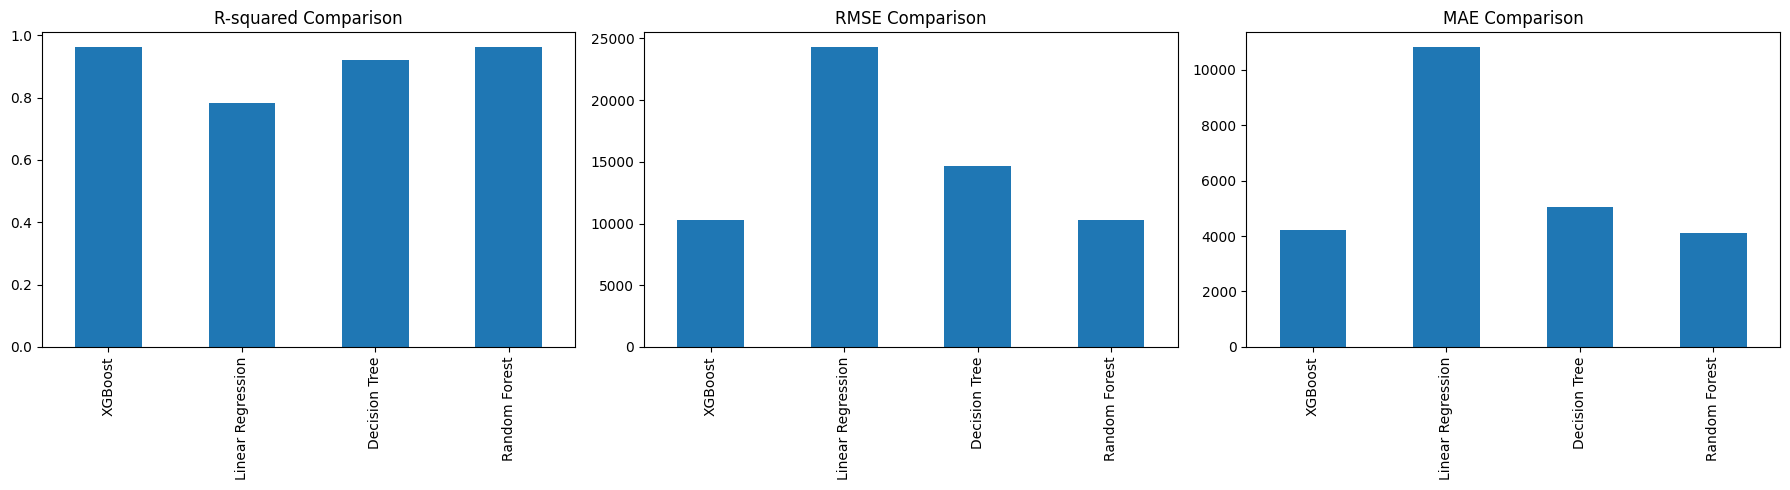

[I 2024-10-10 15:13:00,706] A new study created in memory with name: no-name-8a25dc92-7968-4d92-99c9-b06881526a95
[I 2024-10-10 15:13:04,883] Trial 0 finished with value: 34458.627294738944 and parameters: {'n_estimators': 99, 'max_depth': 2, 'min_samples_split': 15, 'min_samples_leaf': 15}. Best is trial 0 with value: 34458.627294738944.
[I 2024-10-10 15:13:31,240] Trial 1 finished with value: 15089.53829752412 and parameters: {'n_estimators': 243, 'max_depth': 12, 'min_samples_split': 6, 'min_samples_leaf': 9}. Best is trial 1 with value: 15089.53829752412.
[I 2024-10-10 15:14:03,666] Trial 2 finished with value: 16204.84188544283 and parameters: {'n_estimators': 303, 'max_depth': 17, 'min_samples_split': 18, 'min_samples_leaf': 13}. Best is trial 1 with value: 15089.53829752412.
[I 2024-10-10 15:14:46,545] Trial 3 finished with value: 12209.8239124296 and parameters: {'n_estimators': 373, 'max_depth': 18, 'min_samples_split': 11, 'min_samples_leaf': 4}. Best is trial 3 with value: 1

In [ ]:
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import optuna
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings("ignore")

# Data Preprocessing Functions
def translate_to_english(city_name):
    city_mapping = {
        'Bakı': 'Baku',
        'Gəncə': 'Ganja',
        'Sumqayıt': 'Sumgait',
        'Lənkəran': 'Lankaran',
        'Şamaxı': 'Shamakhi',
        'Sabirabad': 'Sabirabad',
        'Salyan': 'Salyan',
        'Masallı': 'Masalli',
        'Şirvan': 'Shirvan',
        'İsmayıllı': 'Ismayilli',
        'Biləsuvar': 'Bilasuvar',
        'Ağdaş': 'Agdash',
        'Tovuz': 'Tovuz',
        'Goranboy': 'Goranboy',
        'Şəki': 'Sheki',
        'Xırdalan': 'Khirdalan',
        'Ağcabədi': 'Agjabadi',
        'Quba': 'Quba',
        'Balakən': 'Balakan',
        'Şəmkir': 'Shamkir',
        'Qazax': 'Qazakh',
        'Mingəçevir': 'Mingachevir',
        'Bərdə': 'Barda',
        'Saatlı': 'Saatli',
        'Xaçmaz': 'Khachmaz',
        'Kürdəmir': 'Kurdamir',
        'Göyçay': 'Goychay',
        'Neftçala': 'Neftchala',
        'Ağsu': 'Agsu',
        'Qəbələ': 'Qabala',
        'Tərtər': 'Tartar',
        'Naxçıvan': 'Nakhchivan',
        'Astara': 'Astara',
        'Qax': 'Qakh',
        'Siyəzən': 'Siyezen',
        'Lerik': 'Lerik',
        'Yevlax': 'Yevlakh',
        'Gədəbəy': 'Gedabay',
        'İmişli': 'Imishli',
        'Zaqatala': 'Zaqatala',
        'Göygöl': 'Goygol',
        'Yardımlı': 'Yardimli',
        'Şabran': 'Shabran',
        'Qusar': 'Qusar',
        'Beyləqan': 'Beylagan',
        'Samux': 'Samukh',
        'Ağdam': 'Agdam',
        'Cəlilabad': 'Jalilabad',
        'Ağstafa': 'Agstafa',
        'Hacıqabul': 'Hajigabul',
        'Ucar': 'Ujar',
        'Füzuli': 'Fuzuli',
        'Qobustan': 'Gobustan',
        'Xudat': 'Khudat',
        'Oğuz': 'Oguz',
        'Zərdab': 'Zardab',
        'Babək': 'Babek',
        'Göytəpə': 'Goytepe',
        'Cəbrayıl': 'Jebrail',
        'Daşkəsən': 'Dashkasan',
        'Naftalan': 'Naftalan',
        'Dəliməmmədli': 'Delimammadli',
        'Şərur': 'Sharur',
        'Horadiz': 'Horadiz',
        'Ordubad': 'Ordubad',
        'Xızı': 'Khizi',
    }
    return city_mapping.get(city_name, city_name)

def extract_engine_power(data, column_name, new_column_name):
    data[new_column_name] = data[column_name].str.extract(r'(\d+\.\d+)').astype(float)
    return data

def extract_ride_km(data, column_name, new_column_name):
    data[new_column_name] = data[column_name].str.replace('[^\d.]', '', regex=True).astype(float)
    return data

def map_values(data, column_name, mapping):
    data[column_name] = data[column_name].apply(lambda value: mapping.get(value, value))
    return data

def separate_price_and_currency(data):
    def helper(price_str):
        price_str = price_str.replace(',', '')
        currency_codes = ['USD', 'EUR', 'GBP', 'AZN', 'JPY', 'RUB']
        for code in currency_codes:
            if code in price_str:
                currency = code
                price = price_str.replace(code, '').strip()
                return price, currency
        return price_str, 'AZN'

    data[['car_price', 'currency']] = data['price'].apply(helper).apply(pd.Series)
    data['car_price'] = pd.to_numeric(data['car_price'].str.replace('[^\d.]', '', regex=True), errors='coerce')
    data['car_price'] = data.apply(lambda row: row['car_price'] * 1.7 if row['currency'] == 'USD' else (
        row['car_price'] * 1.8 if row['currency'] == 'EUR' else row['car_price']), axis=1)
    return data

def preprocess_data(data):
    data['city'] = data['city'].apply(translate_to_english)
    data = map_values(data, 'ban_type', {
        'Offroader / SUV': 'SUV',
        'Sedan': 'Sedan',
        'Hetçbek': 'Hatchback',
        'Universal': 'Station Wagon',
        'Liftbek': 'Liftback',
        'Yük maşını': 'Truck',
        'Furqon': 'Van',
        'Minivan': 'Minivan',
        'Kupe': 'Coupe',
        'Motosiklet': 'Motorcycle',
        'Pikap': 'Pickup',
        'Dartqı': 'Convertible',
        'Mikroavtobus': 'Microbus',
        'Moped': 'Moped',
        'Avtobus': 'Bus',
        'Kabriolet': 'Convertible',
        'Van': 'Van',
        'Rodster': 'Roadster',
        'Kvadrosikl': 'Quad Bike'
    })
    data = map_values(data, 'colour', {
        'Ağ': 'Silver',
        'Qara': 'Black',
        'Gümüşü': 'Silver',
        'Göy': 'Blue',
        'Yaş Asfalt': 'Gray',
        'Boz': 'Brown',
        'Tünd qırmızı': 'Dark_Red',
        'Qırmızı': 'Red',
        'Yaşıl': 'Green',
        'Mavi': 'Blue',
        'Bej': 'Beige',
        'Qızılı': 'Gold',
        'Qəhvəyi': 'Brown',
        'Narıncı': 'Orange',
        'Sarı': 'Yellow',
        'Bənövşəyi': 'Purple',
        'Çəhrayı': 'Pink'
    })
    data = map_values(data, 'transmission', {
        'Avtomat': 'Automatic',
        'Mexaniki': 'Manual',
        'Variator': 'CVT',
        'Robotlaşdırılmış': 'Automated_Manual'
    })
    data = map_values(data, 'gear', {
        'Tam': 'Full',
        'Ön': 'Front',
        'Arxa': 'Rear'
    })
    data = map_values(data, 'is_new', {
        'Bəli': 'Yes',
        'Xeyr': 'No'
    })
    data = extract_engine_power(data, 'engine', 'engine_power')
    data = extract_ride_km(data, 'ride', 'ride_km')
    data = separate_price_and_currency(data)
    return data

# Data Splitting Function
def split_data(data, original_features, target, test_size=0.2, random_state=47):
    data = data.dropna()
    data[original_features].to_excel('preprocessed_data.xlsx', index=False)
    data_copy = pd.get_dummies(data[original_features + [target]], drop_first=True)
    X = data_copy.drop(columns=[target])
    y = data_copy[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test

# Modeling Functions
def train_xgboost_model(X_train, y_train, learning_rate=0.4, max_depth=4, n_estimators=1200):
    model = XGBRegressor(learning_rate=learning_rate, max_depth=max_depth, n_estimators=n_estimators)
    model.fit(X_train, y_train)
    return model

def train_linear_regression_model(X_train, y_train):
    model = LinearRegression()
    model.fit(X_train, y_train)
    return model

def train_decision_tree_model(X_train, y_train):
    model = DecisionTreeRegressor()
    model.fit(X_train, y_train)
    return model

def train_random_forest_model(X_train, y_train):
    model = RandomForestRegressor(n_estimators=100, random_state=47)
    model.fit(X_train, y_train)
    return model

def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    print(f"{model_name} performance metrics")
    print("-----------------------")
    print(f"R-squared: {r2:.2f}")
    print(f"Root Mean Squared Error: {rmse:.2f}")
    print(f"Mean Absolute Error: {mae:.2f}")
    print("-----------------------")
    return r2, rmse, mae

# Optuna Optimization Function
def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 500)
    max_depth = trial.suggest_int("max_depth", 2, 20)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 20)

    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=47
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return mean_squared_error(y_test, y_pred, squared=False)

# Load and preprocess the data
data_1 = pd.read_csv('data/27092023.csv')
data_2 = pd.read_csv('data/08112023.csv')
data = preprocess_data(pd.concat([data_1, data_2]).drop_duplicates().dropna())
original_features = ['city', 'make', 'model', 'year', 'ban_type', 'colour', 'engine_power', 'ride_km', 'transmission','gear', 'is_new']
target = 'car_price'

# Split the data
X_train, X_test, y_train, y_test = split_data(data, original_features, target)

# Train and evaluate models
models = {
    "XGBoost": train_xgboost_model(X_train, y_train),
    "Linear Regression": train_linear_regression_model(X_train, y_train),
    "Decision Tree": train_decision_tree_model(X_train, y_train),
    "Random Forest": train_random_forest_model(X_train, y_train)
}

performance_metrics = {}

for model_name, model in models.items():
    r2, rmse, mae = evaluate_model(model, X_test, y_test, model_name)
    performance_metrics[model_name] = {"R-squared": r2, "RMSE": rmse, "MAE": mae}
    
# Plot performance metrics
metrics_df = pd.DataFrame(performance_metrics).T
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics_df["R-squared"].plot(kind='bar', ax=axes[0], title="R-squared Comparison")
metrics_df["RMSE"].plot(kind='bar', ax=axes[1], title="RMSE Comparison")
metrics_df["MAE"].plot(kind='bar', ax=axes[2], title="MAE Comparison")

plt.tight_layout()
plt.show()

# Run Optuna for Random Forest Optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)
print("Best trial:")
print(study.best_trial)

# Save the optimized Random Forest model
best_params = study.best_params
optimized_model = RandomForestRegressor(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=47
)
optimized_model.fit(X_train, y_train)
joblib.dump(optimized_model, 'optimized_random_forest_model.pkl')